# Семинар 4. Детекция

## 1. Изучаем метрики детекции

### Intersection over union (IoU)

<img src=https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png>


Формула:

$$\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}} = \frac{|A \cap B|}{|A \cup B|}$$

Пример как это выглядит в коде

```python
def intersection_over_union(dt_bbox: np.array, gt_bbox: np.array) -> float:
    """
    Intersection over Union between two bboxes
    (x0, y0) - coordinates of the upper left bbox corner
    (x1, y1) - coordinates of the down right bbox corner

    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    # upper left corner
    int_x0 = max(dt_bbox[0], gt_bbox[0])
    int_y0 = max(dt_bbox[1], gt_bbox[1])
    # bottom right corner
    int_x1 = min(dt_bbox[2], gt_bbox[2])
    int_y1 = min(dt_bbox[3], gt_bbox[3])

    intersection = max(int_x1 - int_x0, 0) * max(int_y1 - int_y0, 0)
    dt_area = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    return intersection / (dt_area + gt_area - intersection)
```

Важные моменты про IoU.

Интерпретация значений:

- IoU >= 0.5: хорошее пересечение (стандартный threshold)
- IoU >= 0.7: отличное пересечение
- IoU >= 0.9: почти идеальное совпадение
- IoU < 0.5: плохое пересечение (обычно FP)

**Threshold в competitions**:

- PASCAL VOC: IoU >= 0.5
- COCO: IoU >= 0.5, 0.55, 0.6, ..., 0.95 (усредняются!)
- Строгие задачи (medical, autonomous driving): IoU >= 0.7


**Проблемы IoU**:

*  Не учитывает размер объекта (маленькие vs большие)
*  Не учитывает форму (квадрат vs вытянутый прямоугольник)
* IoU = 0 если bbox'ы не пересекаются (нет градиента!)

**Альтернативы IoU**:

- GIoU (Generalized IoU): работает даже без пересечения
- DIoU (Distance IoU): учитывает расстояние между центрами
- CIoU (Complete IoU): учитывает aspect ratio




### Mean average precision (mAP)

Базовые метрики: Precision и Recall

Определения
$$Precision = \frac{TP}{TP + FP}$$ — из всех предсказанных боксов, сколько правильных?
$$Recall = \frac{TP}{TP + FN}$$ — из всех ground truth боксов, сколько нашли?

Где:

* TP (True Positive) — правильно найденный объект
* FP (False Positive) — ложное срабатывание
* FN (False Negative) — пропущенный объект


**Правила для Detection**

В задаче детекции метки TP, FP, FN выдаются по следующей логике:
* ✅  TP (True Positive): IoU >= 0.5 И класс правильный
* ❌ FP (False Positive): IoU < 0.5 ИЛИ класс неправильный ИЛИ дубликат бокса
* ❌ FN (False Negative): GT бокс не найден ИЛИ (IoU >= 0.5 но класс неправильный)

#### Чтобы было нагляднее

* зеленый цвет - истинный бокс и класс
* синий - наши предсказания

**True Positive**

У нас два волка, оба определены своим классом и боксы, очевидно, имеют IoU больше 0.5.

<img src="https://github.com/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/TruePositiveVolks.jpg?raw=1">

**False Positive**

Несмотря на то, что класс определен правильно и бокс, в целом, выглядит логично на своем месте, IoU слишком мал, поэтому такая детекция получает метку FP.
<img src="https://github.com/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/FalsePositiveVolk.jpg?raw=1">

**False Negative**

Потому что, несмотря на хорошее пересечение предсказанного бокса с целевым, класс с высокой уверенностью определен неправильно.

<img src="https://github.com/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/FalseNegativeVolk.jpg?raw=1">


Как считается mAP?

Алгоритм:

1. Для каждого класса строим Precision-Recall (PR) кривую
2. Вычисляем Average Precision (AP) = площадь под PR-кривой
3. mAP = среднее AP по всем классам

Формулы:
$$\text{AP} = \int_0^1 P(R) , dR$$ — площадь под Precision-Recall кривой
$$\text{mAP} = \frac{1}{N} \sum_{i=1}^{N} \text{AP}_i$$ — среднее по всем классам

### PR-кривая

Далее, для подсчёта mAP нужно построить PR-кривую. Напомним, что это кривая, у которой по оси Y - значение Precision, а по оси X - значение recall. Эти значения считаются при переборе пороговых вероятностей, начиная с которых объект помечается положительным классом.

Рассмотрим случай, где у нас три класса: Волк, Лев и Тигр.

Внизу представлена таблица с игрушечными данными по предсказаниям модели. Допустим, из 7 объектов в датасете у нас только 3 волка. В данном случае мы называли объект "действительно волком", если он имел правильный класс и IoU не менее 0.5. Получается, имеем задачу вида one vs all, где интересующим нас классом будет являться именно "волк".

|Номер строки| Уверенность в том что волк (истинный класс)    |IoU не менее 0.5?   |  Precision  |  Recall |
|------------|------------------------|----------------------|-------------|---------|
|1           |0.92 (Волк)     |   True    |    1.0     |    0.33 |
|2           |0.83 (Волк)     |   True    |    1.0     |    0.67 |
|3           |0.77 (Волк)     |   False   |    0.67    |    0.67 |
|4           |0.71 (Лев)      |   False   |    0.50    |    ...  |
|5           |0.67 (Тигр)     |   False   |    0.40    |    .... |
|6           |0.54 (Волк)     |   True    |    0.50    |    .... |
|7           |0.47 (Тигр)     |   False   |    0.50    |    1.0  |

<h6>Посчитаем Precision и Recall для порога в 0.9:</h6>
Здесь все легко: взяли порог в 0.9 и называем волками всех, у кого уверенность в классе "Волк" больше 0.9. Один TP, отсутсвуют FP и два FN (2 и 6 строчки).
$$Precision ={  1 \over 1 + 0} = 1.0$$

$$Recall = {1 \over 1 + 2} = 0.33$$

<h6>для порога в 0.8:</h6>
Здесь тоже без дополнительных сложностей: таким порогом во второй строчке у нас нашелся еще один TP, соответственно убавился один FN. Остальное осталось так же.
$$Precision ={  2 \over 2 + 0} = 1.0$$

$$Recall = {2 \over 2 + 1} = 0.67$$

<h6>для порога в 0.75:</h6>  
А вот при пороге в 0.75 в третьей строчке замечаем, что, несмотря на то что истинный класс действительно "Волк" (чем мы и называем данный объект), IoU c истинным боксом меньше 0.5, поэтому присваиваем метку FP.
$$Precision ={  2 \over 2 + 1} = 0.67$$

$$Recall = {2 \over 2 + 1} = 0.67$$

PR кривая будет выглядеть следующим образом:

<img src="https://github.com/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/pr_uno.png?raw=1">

### Монотонная PR-кривая

**Average Precision (AP)** стандартно **определяется как AUC-PR**, то есть как площадь по PR кривой. Из-за того что Precision и Recall находятся в отрезке от 0 до 1, AP также определена на этом отрезке. Чем ближе к 1, тем качественнее модель.

Для удобства вычислений и чуть большей устойчивости к перестановке, вместо того чтобы терпеть возникшую немонотонность (то есть Precision может падать при росте Recall), для всех совпадающих значений recall'a берется максимальный справа от текущей точки precision, то есть график изменится следующим образом:

<img src="https://github.com/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/pr_dos.png?raw=1">

Технология та же: для вычисления AP считается AUC под красной кривой:

$$AP = 1 * 0.67 + (1 - 0.67) * 0.5 = 0.835.$$

### k-point interpolation

В какой-то момент люди решили, что просто площади — теперь не круто и в популярном соревновании PASCAL VOC2008 для вычисления Average Precision использовалась 11-point interpolation.

По простому: брались 11 значений монотонной PR функции, в точках 0, 0.1, 0.2, ..., 0.9, 1.0 и усреднялись. <br>Для любителей формул:

$$AP = {1 \over11} * \sum P(r), r \in [0.1, 0.2, ..., 0.9, 1.0],$$
$P(r)$ — значение Precision при определенном Recall.

Графически это все выглядит следующим образом:

<img src="https://github.com/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/pr_tres.png?raw=1">

Посчитаем АР данным способом:
$$AP = {1 \over {11}} (1 * 7 + 3 * 0.5) = 0.77.$$


**Примечание**: этот метод устарел, но полезно знать для понимания старых статей!

#### Подсчёт mAP и другие метрики в задачах детекции

Для более <font color="green">fresh </font> PASCAl VOC соревнований (2011 - 2012) было принято решение считать **Average Precision** как обычную __площадь под монотонной PR кривой__. Этого определения мы и будем придерживаться далее.

Все предыдущие графики, наша первая табличка и значения AP считались для одного класса "Волк". Понятно, что подобные значения можно посчитать для каждого класса в выборке. И каждый раз будет принцип one vs all, где различаются нужный класс и "все остальные".

Метрика __mean Average Precison__ считается как среднее между __AP__ каждого класса, т.е.:

$$mAP = \sum_{c \in C} AP(c),$$
где С — множество классов.

<br>Ниже пример того, как считать среднее.

*для Average Precision льва и тигра значения взяты случайно

|AP(Волк)| AP(Лев) | AP(Тигр)|mAp    |
|--------|---------|---------|-------|
|0.835   |0.83     | 0.77    | 0.81  |

### Разные версии mAP

| Метрика | IoU Threshold | Где используется |
|---------|---------------|------------------|
| mAP@0.5 | IoU ≥ 0.5 | PASCAL VOC |
| mAP@0.75 | IoU ≥ 0.75 | Строгая оценка |
| mAP@[.5:.95] | Усреднение по IoU ∈ [0.5, 0.55, ..., 0.95] | COCO (стандарт!) |

### Дополнительные метрики COCO

1. `mAP^S` (small): объекты с area < 32²
2. `mAP^M` (medium): 32² < area < 96²
3. `mAP^L` (large): area > 96²

Это помогает понять как модель работает на объектах разного размера!

### Краткая шпаргалка

Основные шаги:

1. Сортируем предсказания по confidence
2. Для каждого threshold считаем TP, FP, FN
3. Вычисляем Precision и Recall
4. Строим монотонную PR-кривую
5. AP = площадь под кривой
6. mAP = среднее AP по классам

Интерпретация:

1. mAP = 1.0 — идеальная модель
2. mAP > 0.5 — хорошая модель
3. mAP < 0.3 — слабая модель

## 3. Детектируем объекты на изображениях при помощи разных архитектур

### Семейства моделей детекции

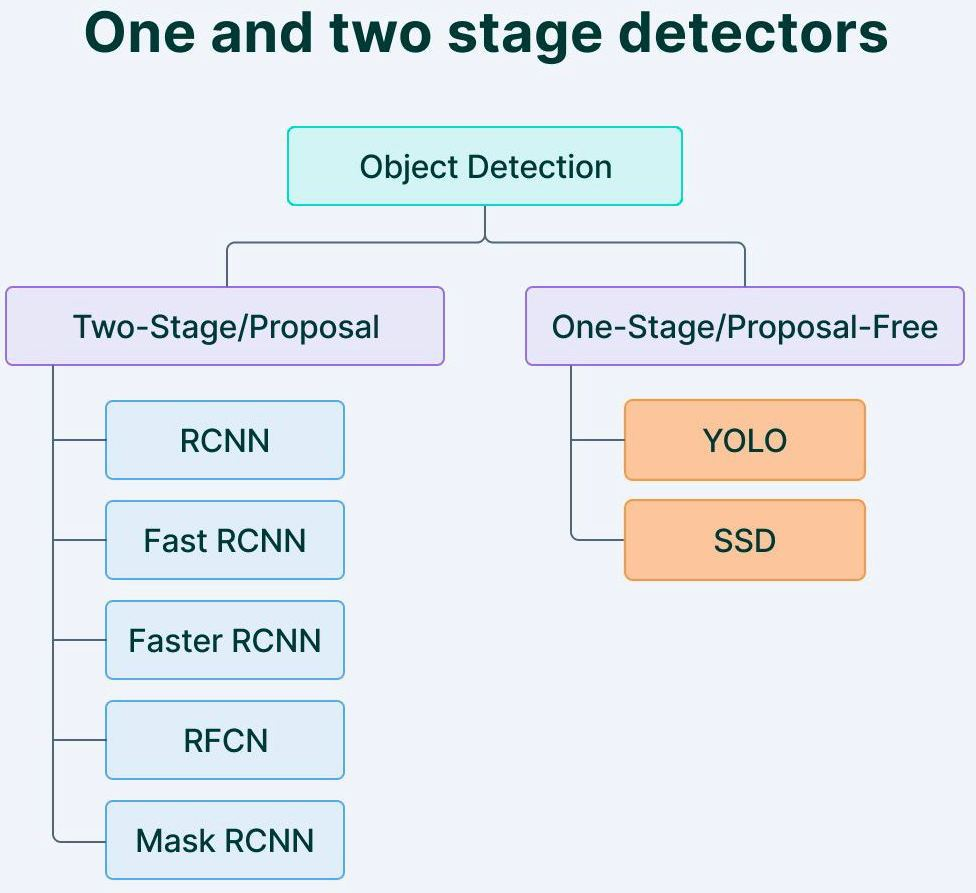

Грубо говоря, можно разделить классический подход к детекции на две основные ветви.


**Основное различие**:

1. Two-Stage: сначала находим region proposals, потом классифицируем
2. One-Stage: сразу предсказываем класс и бокс за один проход


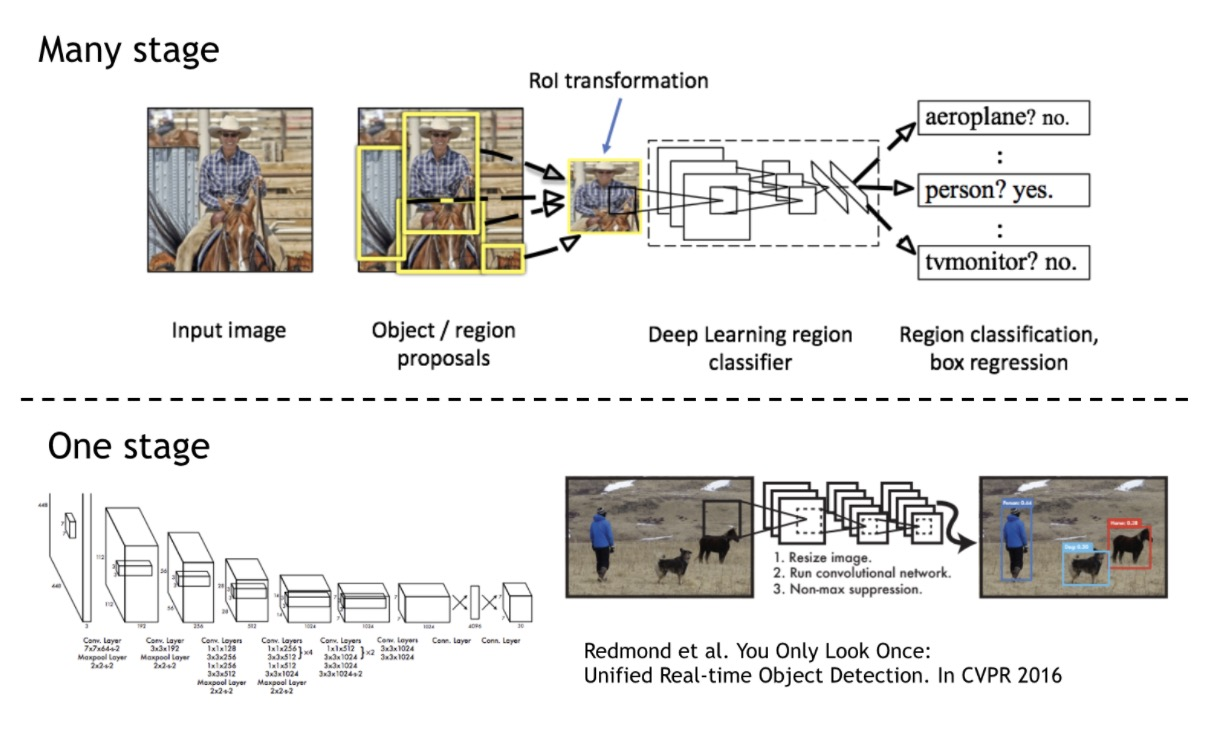

### Non-Maximum Suppression (NMS)

Проблема:

Детектор находит один объект несколько раз:

```
🐕 Собака
    
    ┌─────────┐  0.95
    │ ┌───────┼─┐  0.87
    │ │       │ │
    └─┼───────┘ │
      └─────────┘

```

Нужно оставить ОДИН лучший bbox!


Стандартный жадный алгоритм NMS работает следующим образом:
1. Фильтрация (Thresholding):
Все bbox с уверенностью ниже порога (например, 0.5) сразу отбрасываются для удаления слабых предсказаний.
2. Сортировка (Sorting):
Оставшиеся bbox сортируются по убыванию уверенности.
3. Выбор (Selection):
Bbox с наивысшей уверенностью выбирается как валидная детекция.
4. Подавление (Suppression):
Алгоритм сравнивает выбранный bbox со всеми оставшимися. Если IoU между выбранным и другим bbox превышает порог (например, 0.5), bbox с меньшей уверенностью подавляется (удаляется), так как предполагается что он представляет тот же объект.
5. Итерация (Iteration):
Процесс повторяется для следующего bbox с наивысшей уверенностью, пока все кандидаты не будут обработаны.

Простыми словами: "Из всех перекрывающихся боксов выбираем самый уверенный, остальные выбрасываем."

## Object Detection: Архитектуры


### Selective Search — откуда берутся proposals?


Зачем нужны proposals?

Проблема: на изображении может быть объект где угодно, любого размера

Наивное решение: sliding window на всех позициях и масштабах

1. Изображение 800×600
2. 10 масштабов × 3 соотношения сторон
3. Результат: миллионы окон для проверки!

**Selective Search**: умный способ предложить ~2000 кандидатов


Главная идея:

*Hierarchical grouping* — объединяем похожие регионы снизу вверх

```
Шаг 1: Мелкая сегментация → ~1000 сегментов

Шаг 2: Объединяем похожие по:
       - Цвету (гистограммы RGB)
       - Текстуре (Gaussian derivatives)
       - Размеру (маленькие объединяются первыми)
       - Форме (насколько плотно заполняют bbox)

Шаг 3: Повторяем → иерархия от маленьких к большим

Результат: ~2000 region proposals
```


Почему это работает?
* ✅ Высокий recall — почти всегда находит объекты (~98%)
* ✅ Разнообразие — разные размеры, формы, положения
* ✅ Без обучения — классический CV алгоритм

Но очевидно главная проблема:

```
Selective Search: ~2 секунды на изображение
CNN inference: ~0.3 секунды

→ Selective Search съедает 87% времени!
→ Не обучается под конкретную задачу
→ Не использует GPU
```

Это bottleneck, который решается в Faster R-CNN


Больше деталей вот [здесь](https://www.geeksforgeeks.org/machine-learning/selective-search-for-object-detection-r-cnn/)

<img src="https://media.geeksforgeeks.org/wp-content/uploads/home/step3-660x304.PNG?raw=1">


### R-CNN (2014) — первый deep learning детектор



<img src="https://lh6.googleusercontent.com/L-hLr-fL1mBUzKYMtNOeQZgF0CCw1rmE4230m90o-PctazAed_18_3G9f_FI7Qgo-Z5o3Lf_ZuDwC-YcwpyXpasCAq8xkRB2yHxMucN-sSal7SYsPCiWn558XuRUD2F5xP41h5Stb1Q2xmvHVaSH1LQ?raw=1">

Контекст:

До 2014: лучший результат на PASCAL VOC ~35% mAP (DPM — Deformable Part Models)

R-CNN: 53.3% mAP — революция!

Pipeline:
```
Изображение
    ↓
~2000 proposals от Selective Search
    ↓
CNN + SVM для каждого → scores
    ↓
Bbox regressor → уточнённые координаты
    ↓
Фильтрация по confidence > threshold
    ↓
NMS per class (IoU threshold = 0.3-0.5)
    ↓
Финальные детекты
```

Breakdown времени:
1. Selective Search: ~2 сек
2. 2000 × CNN forward pass: ~45 сек

────────────────────────────────

Итого: ~47 сек на изображение

Основной **bottleneck**: 2000 прогонов через CNN!



Интересные детали:

Почему SVM, а не softmax?

* Изначально пробовали fine-tune CNN с softmax
* SVM на frozen features работал лучше
* Позже (Fast R-CNN) softmax победил при правильном обучении

Bbox regressor:

* Обучается отдельно после CNN+SVM
* Предсказывает 4 offset'а: Δx, Δy, Δw, Δh
* Линейная регрессия от CNN features

Обучение:

* 3 отдельных этапа: CNN → SVM → Bbox regressor
* Не end-to-end!


Плюсы и минусы:
* ✅ Прорыв в точности (53.3% → 66.0% mAP)
* ✅ Первое успешное применение CNN для detection
* ❌ Катастрофически медленно (47 сек/изображение)
* ❌ Три отдельных компонента, сложное обучение
* ❌ Огромное потребление памяти (2000 × features на диск)

### Fast R-CNN (2015) — решаем проблему скорости

**Главная инсайт!**

Проблема R-CNN: одно и то же изображение обрабатывается CNN 2000 раз!

Решение: обработаем один раз, а потом извлечём features для каждого proposal

<img src="https://miro.medium.com/0*Hw4sfqFmVyUAI9TW.jpeg?raw=1">

Архитектура

```
Изображение
    ↓
CNN (VGG16) → Feature map [H×W×512]  ← ОДИН РАЗ!
    ↓
Selective Search → ~2000 proposals (на исходном изображении)
    ↓
ROI Pooling: для каждого proposal извлекаем fixed-size features
    [проецируем proposal на feature map → 7×7×512]
    ↓
FC layers → 4096-d
    ↓
    ├→ Softmax (K+1 классов) → класс + confidence
    └→ Bbox regressor (4×K) → уточнённые координаты
    ↓
Фильтрация (confidence > threshold)
    ↓
NMS per class
    ↓
Финальные детекты
```

ROI Pooling — ключевая инновация:

Проблема: proposals разного размера, а FC слоям нужен фиксированный input


Решение:

```
1. Проецируем proposal на feature map
   (с учётом downsampling: делим координаты на 16)
2. Делим projected region на сетку 7×7
3. Max pooling в каждой ячейке
4. Результат: всегда 7×7, независимо от размера proposal
```

Плюсы и минусы:
* ✅ В 20× быстрее R-CNN
* ✅ End-to-end обучение (почти — кроме proposals)
* ✅ Выше точность при меньшей сложности
* ❌ Selective Search всё ещё медленный
* ❌ Не real-time (~0.5 fps)

### Faster R-CNN (2015) — полностью обучаемый детектор

Главная идея:

**Проблема**: Selective Search занимает 87% времени и не *обучается*

**Нейросеть: VGG16**

**Решение**: заменяем на обучаемую нейросеть — Region Proposal Network (RPN)

<img src="https://doimages.nyc3.cdn.digitaloceanspaces.com/010AI-ML/content/images/2020/09/Fig05-2.jpg?raw=1">

Архитектура

```
Изображение
    ↓
Shared CNN (backbone) → feature map
    ↓
    ├→ RPN → proposals (обучаемый!)
    │     ↓
    │   NMS
    │     ↓
    └─→ ROI Pooling
         ↓
    FC layers
    ├→ Classifier → класс
    └→ Bbox regressor → координаты
```

#### Что такое RPN (Region Proposal Network)?

RPN — это небольшая нейросеть, которая "скользит" по feature map и предсказывает:

* Есть ли объект? (objectness score)

* Как поправить bbox? (bbox regression)

**Ключевой механизм: Anchor Boxes**

#### Что такое Anchor Boxes?

Anchor Boxes — это заранее заданные "шаблоны" bounding boxes разных размеров и форм.

#### Как работают Anchor Boxes:

1. Для каждой точки на feature map создаем несколько anchor boxes:

    * Обычно 3 масштаба × 3 соотношения = 9 anchor boxes на точку

    * Пример: 128×128, 256×256, 512×512 (масштабы)

    * Соотношения: 1:1, 1:2, 2:1

2. На каждом anchor box RPN предсказывает:

    * objectness score (вероятность, что там объект)

    * bbox adjustments (поправки к координатам; насколько сдвинуть anchor, чтобы лучше попасть в объект)


<img src="https://datadrivenscience.com/wp-content/uploads/elementor/thumbs/anchor-boxes-qd8qcceloi4053qf9nwbk1cwnx3pmnwfqdp1b03pj4.png?raw=1">


#### Детали работы RPN:

Вход:
* Feature map от shared CNN (например, 60×40×512)

Процесс:
* Скользящее окно 3×3 по feature map (чтобы учесть контент вокруг точки; используем паддинг, чтобы сохранить размерность)

* Для каждого положения → 512-d feature vector

* Для каждого anchor box в этой точке:

    * Классификатор: object vs background (9 anchors × 2 scores)

    * Регрессор: 4 числа (dx, dy, dw, dh) для уточнения bbox (9 anchors × 4 coords)


То есть, что у нас есть:

**Шаг 1:**
```
Исходное изображение: 800×600 пикселей
    ↓ (CNN с stride=16)
Feature map: 50×37×512

Каждая точка на feature map "отвечает" за регион 16×16 на исходном изображении
```

---

**Шаг 2:**

У нас 9 размеров Anchor Boxes:

* 128×128 пикселей
* 256×256 пикселей
* 512×512 пикселей
* 128×256 пикселей (1:2)
* 256×128 пикселей (2:1)
* ...и так далее

---

**Шаг 3**

Где располагаются anchors?
Для каждой точки (i, j) на feature map мы создаём 9 anchor boxes:

Центр всех 9 anchors:

```python
center_x = (i + 0.5) * 16  # в пикселях исходного изображения
center_y = (j + 0.5) * 16
```

Пример: точка `(10, 20)` на feature map
```python
center_x = (10 + 0.5) * 16 = 168 пикселей
center_y = (20 + 0.5) * 16 = 328 пикселей
```

---

**Шаг 4**

**Все anchors с центром в (168, 328):**
```
Anchor 1: 128×128, центр (168, 328)
    → bbox: [168-64, 328-64, 168+64, 328+64] = [104, 264, 232, 392]

Anchor 2: 256×256, центр (168, 328)
    → bbox: [168-128, 328-128, 168+128, 328+128] = [40, 200, 296, 456]

Anchor 3: 512×512, центр (168, 328)
    → bbox: [168-256, 328-256, 168+256, 328+256] = [-88, 72, 424, 584]
    (может выходить за границы — это нормально!)

Anchor 4: 128×256 (1:2), центр (168, 328)
    → bbox: [168-64, 328-128, 168+64, 328+128] = [104, 200, 232, 456]

...и так далее для всех 9 комбинаций
```

---

**Шаг 5: Что делает RPN?**
Для каждого из 9 anchors RPN предсказывает:

1. Objectness score (2 числа): вероятность объекта vs фона
2. Offsets (4 числа): насколько сдвинуть anchor, чтобы лучше попасть в объект

```python
# Для anchor 1 (128×128, центр 168, 328):
RPN выдаёт:
    objectness = 0.9  (высокая вероятность объекта)
    Δx = 0.1   (сдвинуть центр вправо на 0.1 × 128 = 12.8 пикселей)
    Δy = -0.05 (сдвинуть центр вверх на 0.05 × 128 = 6.4 пикселей)
    Δw = 0.2   (ширина × exp(0.2) ≈ ширина × 1.22)
    Δh = 0.15  (высота × exp(0.15) ≈ высота × 1.16)
```

---

**Шаг 6: Декодируем в финальный bbox**

```python
anchor_center_x = 168
anchor_center_y = 328
anchor_width = 128
anchor_height = 128

# Применяем offsets от RPN
pred_center_x = 168 + 0.1 × 128 = 180.8
pred_center_y = 328 - 0.05 × 128 = 321.6
pred_width = 128 × exp(0.2) = 156
pred_height = 128 × exp(0.15) = 149

# Финальный bbox
bbox = [180.8 - 156/2, 321.6 - 149/2,
        180.8 + 156/2, 321.6 + 149/2]
```


#### ROI Pooling. Again!

```
Для каждого из 300 proposals:
    ↓
Проецируем на feature map
    ↓
ROI Pooling → 7×7×512 features
    ↓
300 × (7×7×512) feature vectors
```

Теперь делаем detection head!

```
Для каждого из 300 proposals:
    ↓
FC layers → 4096-d
    ↓
    ├→ Classifier → [K+1] scores (K классов + фон)
    │   Пример: [0.05 фон, 0.8 собака, 0.1 кошка, 0.02 машина, ...]
    │
    └→ Bbox regressor → 4×K offsets (для каждого класса свои)
        Пример: для класса "собака": [Δx, Δy, Δw, Δh]
```

И получаем, что теперь у каждого proposal:
* `K+1` классовых вероятностей
* 4 координаты уточнённого bbox (для каждого класса)


Предпоследний шаг — фильтрация по классам!

```
Для каждого из 300 proposals:
    
1. Берём максимальную классовую вероятность
   Пример: max([0.05, 0.8, 0.1, 0.02, ...]) = 0.8 (собака)
   
2. Если вероятность < threshold (обычно 0.5):
   → отбрасываем proposal
   
3. Если класс = "фон":
   → отбрасываем proposal

Результат: ~50-100 proposals с классами (не фон) и confidence > 0.5
```

И затем финальный NMS per class, который выдаёт нам наиболее вероятный bbox, фух!

## **Визуализация всего pipeline. Напоследок более явная структированная архитектура :)**
```
Изображение
    ↓
CNN → Feature map
    ↓
RPN
    ├→ 16,650 anchors (50x37x512 размер feature map)
    ├→ Objectness scores
    └→ Offsets
    ↓
NMS #1 (по objectness, IoU=0.7)
    ↓
300 proposals
    ↓
ROI Pooling
    ↓
Detection Head
    ├→ Classifier (K+1 классов)
    └→ Bbox regressor (4×K offsets)
    ↓
Фильтрация (confidence > 0.5, класс ≠ фон)
    ↓
~50-100 proposals с классами
    ↓
NMS #2 per class (IoU=0.5)
    ↓
5-20 финальных детектов
```

---

## **Два NMS — почему?**

### **NMS #1 (после RPN):**
- **Цель:** убрать дубликаты proposals
- **Критерий:** только objectness (объект/фон)
- **Threshold:** IoU > 0.7 (довольно мягкий)
- **Результат:** 300 candidates для второго этапа

### **NMS #2 (после Detection):**
- **Цель:** убрать дубликаты **для каждого класса**
- **Критерий:** class confidence + IoU
- **Threshold:** IoU > 0.5 (более строгий)
- **Per class:** отдельно для собак, кошек, машин, и т.д.
- **Результат:** финальные детекты

---

## **Пример с цифрами:**
```
16,650 anchors
    ↓ (objectness > 0.5)
6,000 proposals
    ↓ (NMS #1, IoU=0.7)
300 proposals
    ↓ (ROI Pooling + Detection Head)
300 proposals с классами и confidence
    ↓ (confidence > 0.5, класс ≠ фон)
80 proposals
    ↓ (NMS #2 per class, IoU=0.5)
12 финальных детектов:
    - 5 собак
    - 3 кошки
    - 2 машины
    - 2 человека

#### Почему Two-Stage всё ещё актуален?

Плюсы:

* ✅ Высокая точность (state-of-the-art до появления transformers)
* ✅ Хорошо работает на малых объектах
* ✅ Основа для Mask R-CNN (instance segmentation)

Минусы:

* ❌ Медленнее One-Stage (YOLO, SSD)
* ❌ Сложная архитектура
* ❌ Много гиперпараметров (anchors, NMS thresholds)

## YOLO — You Only Look Once

### Главная философия: детекция как регрессия

**Faster R-CNN подход:**
* Генерируем proposals → классифицируем → уточняем bbox
* Два этапа, сложный pipeline

**YOLO подход:**
* Смотрим на изображение **один раз**
* Сразу предсказываем класс + bbox координаты
* Детекция = задача регрессии!

---

### YOLOv1 — ключевая идея

Изображение делится на сетку **S×S** (по умолчанию 7×7 = 49 ячеек).

**Принцип ответственности:**
Если центр объекта попадает в ячейку → эта ячейка отвечает за детекцию данного объекта.

![image.png](https://pyimagesearch.com/wp-content/uploads/2018/11/yolo_design.jpg)

---

### Что предсказывает каждая ячейка?

**1. B bounding boxes** (по умолчанию B=2)

Каждый bbox описывается **5 параметрами:**
* `(x, y)` — координаты центра относительно ячейки
* `(w, h)` — ширина и высота относительно изображения
* `confidence` — уверенность в наличии объекта

$$\text{confidence} = P(\text{Object}) \times \text{IoU}$$

где:
* $P(\text{Object})$ — вероятность, что в bbox есть объект
* $\text{IoU}$ — насколько хорошо bbox покрывает объект


---

**2. C class probabilities** (для каждой ячейки)

Если модель обучена на 20 классах → 20 вероятностей:

$$P(\text{class}_i | \text{Object})$$

**Важно:**

* Вероятности классов предсказываются один раз на ячейку, а не для каждого bbox!
* Это означает что оба bbox в ячейке будут иметь одинаковые классовые вероятности
* Ячейка "решает" какой класс объекта в ней находится

Почему так сделано?

* Упрощает архитектуру
* Предполагается, что в одной ячейке обычно один объект
* Проблема: если центры двух объектов в одной ячейке → детектируется только один!

---

### Итоговый output

Для **каждой ячейки** предсказывается:
* B × 5 параметров bbox = 2 × 5 = **10 чисел**
* C class probabilities = **20 чисел**

**Итого:** 7 × 7 × (10 + 20) = 7 × 7 × 30 = **1470 чисел**

Финальный tensor: **7×7×30**

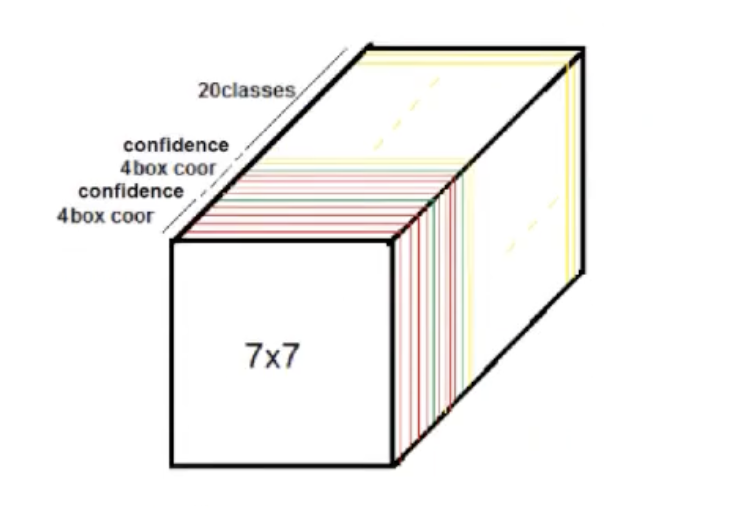


---

### Финальная классовая уверенность

На этапе inference:

$$\text{class-specific confidence} = P(\text{class}_i | \text{Object}) \times P(\text{Object}) \times \text{IoU}$$

$$= P(\text{class}_i) \times \text{IoU}$$

Эта метрика показывает:
* Вероятность что в bbox находится объект класса $i$
* Насколько точно bbox покрывает объект

### Как выглядит инференс?


Шаг 1: Декодируем координаты

Для каждой ячейки (i, j) и каждого bbox:

```python
# Предсказания модели (относительные):
x_pred = 0.3  # относительно ячейки (0-1)
y_pred = 0.7
w_pred = 0.4  # относительно изображения (0-1)
h_pred = 0.5
confidence = 0.85

# Декодируем в абсолютные координаты (пиксели):
cell_size = 448 / 7 = 64

center_x = (i + x_pred) × cell_size
         = (3 + 0.3) × 64 = 211.2 пикселей

center_y = (j + y_pred) × cell_size
         = (2 + 0.7) × 64 = 172.8 пикселей

width = w_pred × 448 = 0.4 × 448 = 179.2 пикселей
height = h_pred × 448 = 0.5 × 448 = 224 пикселей

# Переводим в [x1, y1, x2, y2]:
x1 = center_x - width/2 = 211.2 - 89.6 = 121.6
y1 = center_y - height/2 = 172.8 - 112 = 60.8
x2 = center_x + width/2 = 211.2 + 89.6 = 300.8
y2 = center_y + height/2 = 172.8 + 112 = 284.8

bbox = [121.6, 60.8, 300.8, 284.8]
```

Шаг 2: Вычисляем class-specific confidence

Для каждой ячейки, каждого bbox, каждого класса:

```python
# Ячейка (3, 2):
class_probs = [P(dog)=0.9, P(cat)=0.05, P(car)=0.03, ...]
confidence_bbox1 = 0.85
confidence_bbox2 = 0.3

# Для bbox1, класс "dog":
score = confidence_bbox1 × P(dog)
      = 0.85 × 0.9
      = 0.765

# Для bbox1, класс "cat":
score = confidence_bbox1 × P(cat)
      = 0.85 × 0.05
      = 0.0425

# Для bbox2, класс "dog":
score = confidence_bbox2 × P(dog)
      = 0.3 × 0.9
      = 0.27
```

**Делаем это для всех комбинаций:**
```
7 × 7 ячеек × 2 bbox × 20 классов = 1960 scores!
```

Шаг 3: Фильтрация по threshold

Оставляем только те, где `score > threshold` (обычно 0.3):

```python
candidates = []

for i in range(7):  # строки
    for j in range(7):  # столбцы
        for b in range(2):  # bbox (0 или 1)
            
            # Декодируем bbox
            bbox = decode_bbox(tensor[i, j, b*5:(b+1)*5], i, j)
            confidence = tensor[i, j, b*5 + 4]
            
            # Class probabilities (общие для ячейки!)
            class_probs = tensor[i, j, 10:30]
            
            for c in range(20):  # классы
                score = confidence × class_probs[c]
                
                if score > 0.3:  # threshold
                    candidates.append({
                        'bbox': bbox,
                        'class': c,
                        'score': score
                    })

# Результат: ~50-200 кандидатов (из 1960 возможных)
```

Шаг 4: NMS per class

Для каждого класса отдельно.


### YOLO: ключевые улучшения после v1
#### YOLOv3 (2018) — Multi-Scale Detection

Главная проблема YOLOv1:

Сетка 7×7 слишком грубая → маленькие объекты не детектируются

Решение:

Детекция на ТРЁХ масштабах одновременно

```
52×52 → детектирует маленькие объекты (больше деталей)
26×26 → детектирует средние объекты
13×13 → детектирует большие объекты (больше контекста)
```

Почему это работает:

Feature Pyramid — заимствовали из FPN:

* Глубокие слои (13×13) видят весь контекст, хороши для больших объектов
* Мелкие слои (52×52) сохраняют детали, хороши для маленьких объектов
* Средние слои (26×26) — баланс

Каждый масштаб отвечает за свой диапазон размеров


Anchors:

9 anchors total (по 3 на каждый масштаб):

* 52×52: маленькие anchors
* 26×26: средние anchors
* 13×13: большие anchors

Результат:

* +10% mAP для маленьких объектов
* Стал стандартом — все modern детекторы используют multi-scale

Ключевое отличие от v1:

```
YOLOv1: одна сетка 7×7
        → плохо с маленькими объектами

YOLOv3: три сетки (13×13, 26×26, 52×52)
        → хорошо для ВСЕХ размеров
```

#### YOLOv8 (2023) — Anchor-Free + Modern Architecture

Главная идея:

Вернуться к anchor-free подходу, но сделать правильно


Что изменилось:
1. Отказ от Anchors


Проблема anchors (v2-v7):

* Нужно подбирать размеры (K-means, AutoAnchor)
* Много гиперпараметров
* Зависимость от датасета
* Сложность

YOLOv8 — прямое предсказание:

Модель предсказывает напрямую:

* Центр объекта (x, y)
* Размер (w, h)
* Класс

Как в YOLOv1, но с улучшениями!

2. Decoupled Head

* YOLOv1-7: одна голова для всего
* YOLOv8: две отдельные головы


```
Feature map
    ↓
    ├→ Classification head → классы
    └→ Localization head → координаты

Отдельные головы специализируются!
```


Почему лучше:

* Classification и localization — разные задачи
* Отдельные головы обучаются эффективнее
* Заимствовано из Faster R-CNN (там тоже две головы)

---

3. Task-Aligned Assigner

Проблема: как назначить ground truth к predictions?

* YOLOv1-7: простые правила (IoU threshold)
* YOLOv8: умное назначение:

    * Учитывает и classification score, и IoU
    * Динамически во время обучения
    * Лучшие targets → лучше обучение

---

4. C2f Module (улучшенный CSP)

Более эффективный backbone:

* Меньше параметров
* Выше точность
* Быстрее inference


В ИТОГЕ!
* v1: базовая идея
* v3: добавили multi-scale для маленьких объектов
* v8: упростили и модернизировали архитектуру

In [4]:
# Install ultralytics
!pip install ultralytics

# Run detection on an image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.4 MB/s eta 0:00:00


Видно, как быстро обучается yolo модель, давайте прогоним на инференс.

## Домашка

Заполните пропуски, познакомьтесь с библиотекой :)

In [21]:
# !pip install ultralytics

from ultralytics import YOLO
import matplotlib.pyplot as plt
import time


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


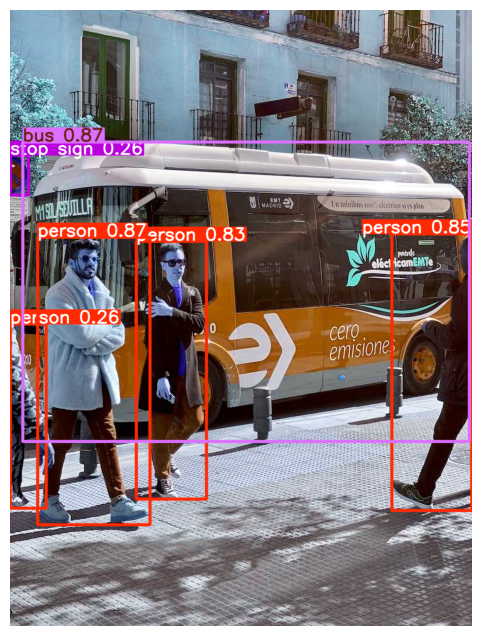

In [24]:
# ============================================
# ЧАСТЬ 1: Первый инференс
# ============================================

model = YOLO(_____)  # TODO: загрузи модель yolov8n.pt

image_url = "https://ultralytics.com/images/bus.jpg"
results = model.predict(source=_____, conf=_____)  # TODO: source и порог уверенности

# Визуализация
plt.figure(figsize=(10, 8))
plt.imshow(_____)  # TODO: results[0].plot() возвращает картинку
plt.axis('off')
plt.show()

print(f"Найдено объектов: {_____}")  # TODO: сколько боксов?

In [27]:
# ============================================
# ЧАСТЬ 2: Эксперимент с conf threshold
# ============================================

# Прогони детекцию с разными порогами и заполни таблицу

for conf in [0.1, 0.25, 0.5, 0.75]:
    results = model.predict(source=image_url, conf=_____, verbose=False)  # TODO
    num_boxes = _____  # TODO
    print(f"conf={conf}: {num_boxes} объектов")

# ВОПРОС: почему при conf=0.75 объектов меньше?
# ОТВЕТ: ___

In [30]:
# ============================================
# ЧАСТЬ 3: Сравнение размеров модели
# ============================================

image_url = "https://ultralytics.com/images/zidane.jpg"

for model_name in ["yolov8n.pt", "yolov8s.pt", "yolov8m.pt"]:
    model = YOLO(_____)  # TODO

    start = time.time()
    results = model.predict(source=image_url, verbose=False)
    elapsed = _____  # TODO: вычисли время

    print(f"{model_name}: {elapsed:.3f} сек, найдено {len(results[0].boxes)} объектов")

# ВОПРОС: какая модель быстрее? Какая точнее?
# ОТВЕТ: ___

Found https://ultralytics.com/images/zidane.jpg locally at zidane.jpg
yolov8n.pt: 0.053 сек, найдено 3 объектов
Found https://ultralytics.com/images/zidane.jpg locally at zidane.jpg
yolov8s.pt: 0.175 сек, найдено 3 объектов
Found https://ultralytics.com/images/zidane.jpg locally at zidane.jpg
yolov8m.pt: 0.321 сек, найдено 5 объектов


In [ ]:
# ============================================
# ЧАСТЬ 4: Работа с результатами
# ============================================

model = YOLO("yolov8n.pt")
results = model.predict(source=image_url, conf=0.25)
boxes = results[0].boxes

# Выведи информацию о каждом найденном объекте
for i in range(len(boxes)):
    class_id = int(boxes.cls[i])
    class_name = model.names[_____]  # TODO: получи имя класса
    confidence = float(boxes.conf[_____])  # TODO: уверенность i-го бокса
    x1, y1, x2, y2 = boxes.xyxy[i].tolist()

    area = _____  # TODO: вычисли площадь бокса

    print(f"{class_name}: conf={confidence:.2f}, area={area:.0f}px")

In [ ]:
# ============================================
# ЧАСТЬ 5: Эксперимент с NMS (iou threshold)
# ============================================

# IOU threshold влияет на то, как агрессивно убираются пересекающиеся боксы

for iou in [0.3, 0.5, 0.7, 0.9]:
    results = model.predict(source=image_url, conf=0.25, iou=_____, verbose=False)  # TODO
    print(f"iou={iou}: {_____} объектов")  # TODO

# ВОПРОС: при каком iou больше боксов? Почему?
# ОТВЕТ: ___

In [ ]:
# ============================================
# ЧАСТЬ 6: Обучение на своём датасете
# ============================================

# 1. Зайди на https://universe.roboflow.com/
# 2. Найди любой небольшой датасет (котики, машины, покемоны...)
# 3. Скачай в формате YOLOv8
# 4. Распакуй в папку dataset/

model = YOLO("yolov8n.pt")

model.train(
    data=_____,   # TODO: путь к data.yaml
    epochs=_____,  # TODO: 10-15 для начала
    imgsz=640,
    batch=16,
    name="my_detector"
)

In [ ]:
# ============================================
# ЧАСТЬ 7: Оценка обученной модели
# ============================================

trained_model = YOLO(_____)  # TODO: путь runs/detect/my_detector/weights/best.pt

metrics = trained_model.val()

print(f"mAP50: {_____}")     # TODO: metrics.box.map50
print(f"mAP50-95: {_____}")  # TODO: metrics.box.map

# Протестируй на своей картинке
results = trained_model.predict(source="путь/к/картинке", conf=0.25)
plt.imshow(results[0].plot())
plt.show()